In [1]:
# Authors: Samantha Tetef and Vikram Kashyap
# Date: Winter 2020-2021 to Summer 2021

In [1]:
import warnings
warnings.filterwarnings("ignore")

import utils as u
from importlib import reload
# to reload utils, run:
# u = reload(u)

import os
import copy
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import mplcursors
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path
from collections import defaultdict

import webbrowser

warnings.filterwarnings("ignore")

In [84]:
u = reload(u)

In [3]:
%matplotlib notebook

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

In [2]:
ROOTDIR = Path()

DataDir = ROOTDIR/"ProcessedData"
ListDir = ROOTDIR/"Categories"

XES_data = u.get_Data(ListDir, mode='xes')
XANES_data = u.get_Data(ListDir, mode='xanes')

In [3]:
if len(XES_data) != len(XANES_data): raise Exception('Unmatched XES and XANES data')
else: print(len(XES_data))

772


In [ ]:
CIDs = [c['CID'] for c in XANES_data]

# ML and Data Science section

In [4]:
typecodemap = {compound['CID']:compound['Type'] for compound in XANES_data}
classcodemap = {compound['CID']:u.CLASS_DICT[compound['Class']] for compound in XANES_data}
colormap_bytype = {compound['CID']:u.colorbynumber(typecodemap[compound['CID']]) for compound in XANES_data}

KeyError: 'dithiophosphate'

<IPython.core.display.Javascript object>


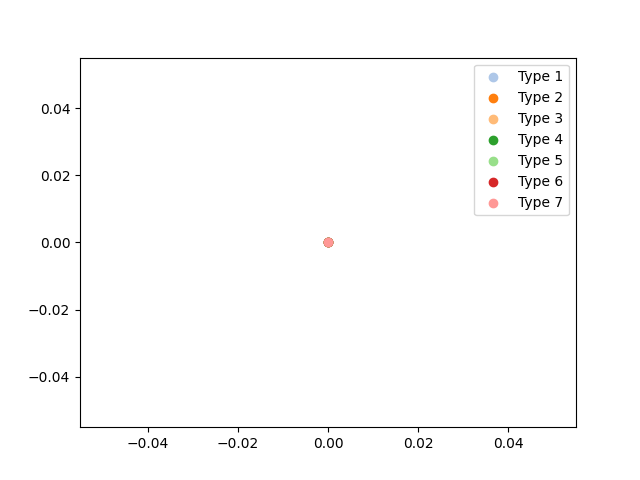

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

In [17]:
plt.figure()
for t in range(1,8):
    plt.scatter(0,0,label=f"Type {t}",c=u.colorbynumber(t))
plt.legend()

## All Spectra Together

<IPython.core.display.Javascript object>


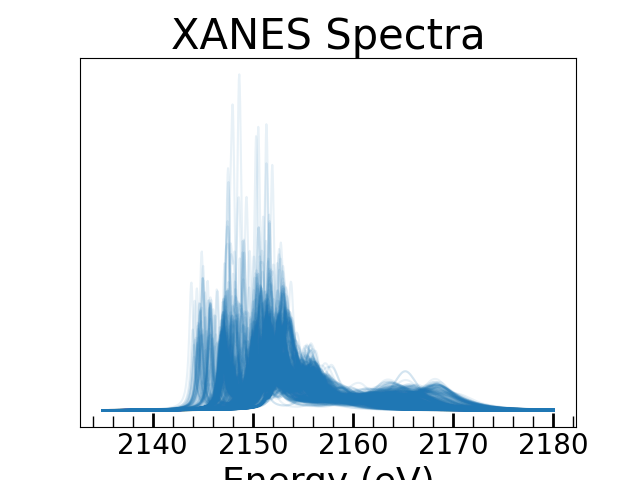

<IPython.core.display.Javascript object>


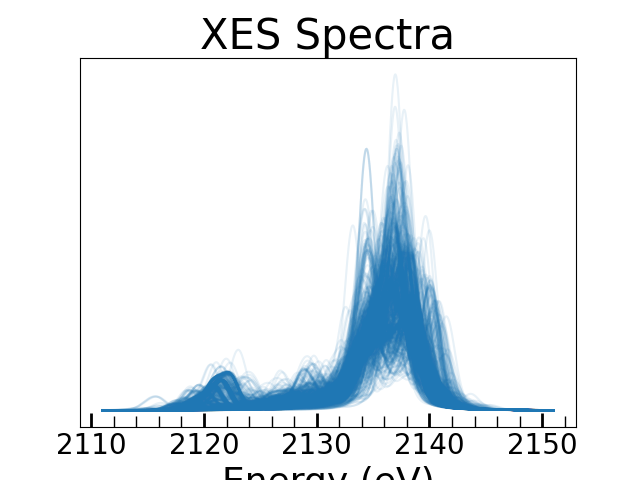

In [18]:
xanesplot = u.plot_spaghetti(plt.subplots(), XANES_data, mode='XANES', coloralpha=0.1);
u.plot_spaghetti(plt.subplots(), XES_data, mode='XES', coloralpha=0.1);

u.add_pubchem_link(xanesplot, XANES_data)

## Rainbow Spaghetti Plot: Color by Compound Type

<IPython.core.display.Javascript object>


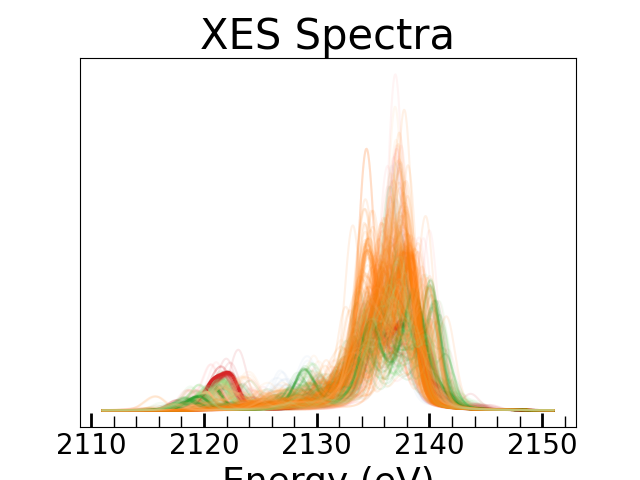

In [19]:
u.plot_spaghetti(plt.subplots(), XES_data, colormap=typecodemap, mode='XES', coloralpha=0.1);

## Rainbow Spaghetti Plot: Color and Stack by Compound Type

<IPython.core.display.Javascript object>


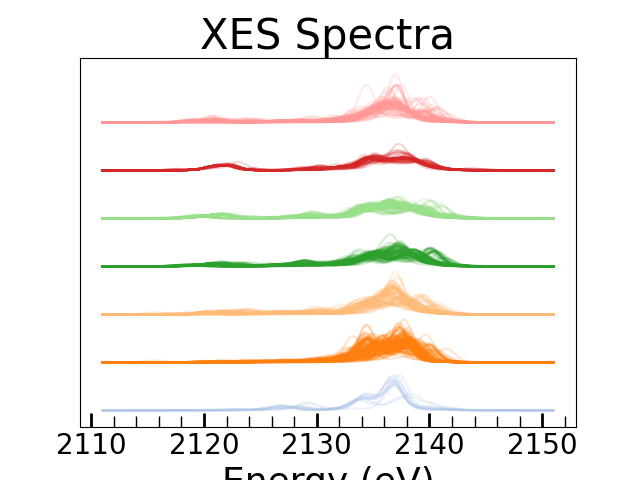

<IPython.core.display.Javascript object>


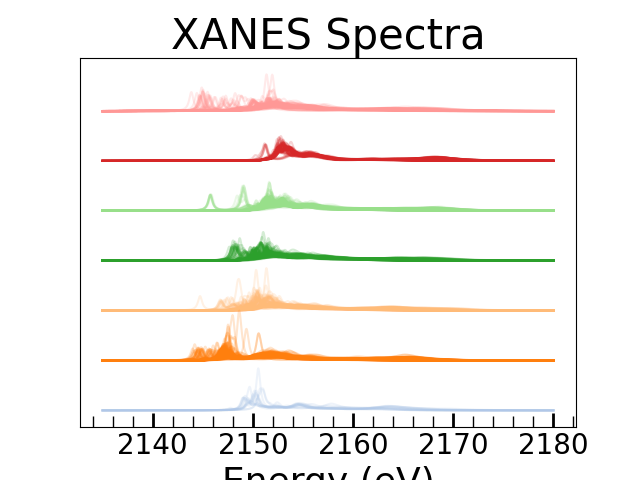

In [20]:
xes_stackplot = u.plot_spaghetti(plt.subplots(), XES_data, \
        colormap=typecodemap, binmap=typecodemap, mode='XES', coloralpha=0.2);
xanes_stackplot = u.plot_spaghetti(plt.subplots(), XANES_data, \
        colormap=typecodemap, binmap=typecodemap, mode='XANES', coloralpha=0.2);

#u.add_label(xes_stackplot, XES_data)
u.add_pubchem_link(xanes_stackplot, XANES_data)

## ML Reduced Space: PCA and T-SNE

In [21]:
warnings.filterwarnings("ignore")

XES = [compound['Normalized'] for compound in XES_data]
XANES = [compound['Normalized'] for compound in XANES_data]

# pca
pca1 = PCA(n_components=10)
XES_PCA = pca1.fit_transform(XES)

# pca
pca2 = PCA(n_components=10)
XANES_PCA = pca2.fit_transform(XANES)

# tsne
tsne = TSNE(n_components=2, perplexity=20)
XES_TSNE = tsne.fit_transform(XES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=30)
XANES_TSNE = tsne.fit_transform(XANES)


# Make CID->point maps
XANES_tsnemap = {compound['CID']:point for compound,point in zip(XANES_data, XANES_TSNE)}
XES_tsnemap = {compound['CID']:point for compound,point in zip(XES_data, XES_TSNE)}

<IPython.core.display.Javascript object>


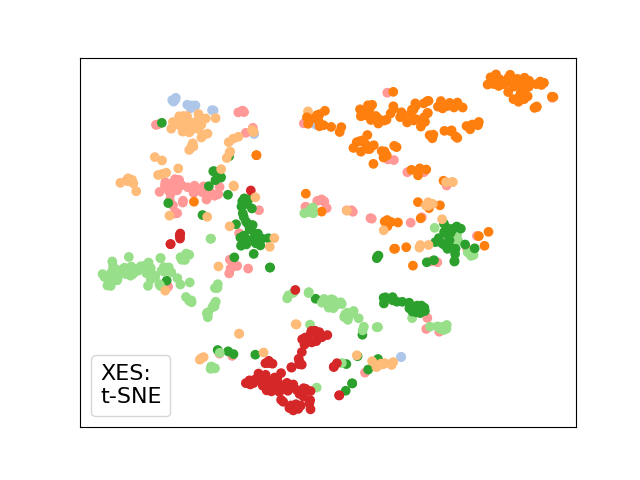

<IPython.core.display.Javascript object>


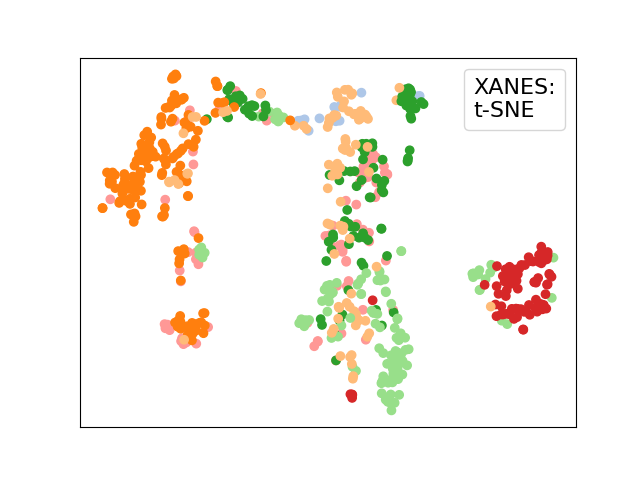

AttributeError: 'PathCollection' object has no attribute 'legend'

In [23]:
xesplot = u.plot_dim_red(plt.subplots(), XES_data, XES_tsnemap, colormap=typecodemap, mode='XES', method='t-SNE')
xanesplot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, colormap=typecodemap, mode='XANES', method='t-SNE')

u.add_label(xesplot, XES_data)
u.add_label(xanesplot, XANES_data)

## Reduced Space: Algorithmic Clustering

In [17]:
# Uncomment and run the line below to stop it linking to PubChem when you click on the figures
linktopubchem = False

In [24]:
from sklearn.cluster import DBSCAN

In [194]:
# Assigns clustermap vars
def runclustering(new_eps, new_min_samples=1):
    global XANES_clustering, XANES_clustermap, XES_clustering, XES_clustermap
    XANES_clustering = DBSCAN(eps=new_eps, min_samples=new_min_samples).fit(XANES_TSNE)
    XANES_clustermap = {compound['CID']:cluster for compound,cluster in zip(XANES_data, XANES_clustering.labels_)}

    XES_clustering = DBSCAN(eps=new_eps, min_samples=new_min_samples).fit(XES_TSNE)
    XES_clustermap = {compound['CID']:cluster for compound,cluster in zip(XES_data, XES_clustering.labels_)}

In [195]:
runclustering(3)

<IPython.core.display.Javascript object>


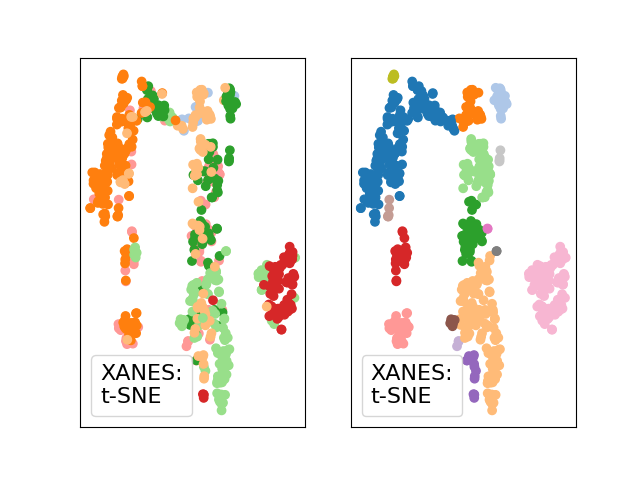

In [128]:
fig, axes = plt.subplots(1,2)
subplots = [(fig, ax) for ax in axes]

redspace_dots_clustered = u.plot_dim_red(subplots[0], XANES_data, XANES_tsnemap, typecodemap, mode='XANES')

redspace_dots_categorized = u.plot_dim_red(subplots[1], XANES_data, XANES_tsnemap, XANES_clustermap, mode='XANES')

<IPython.core.display.Javascript object>


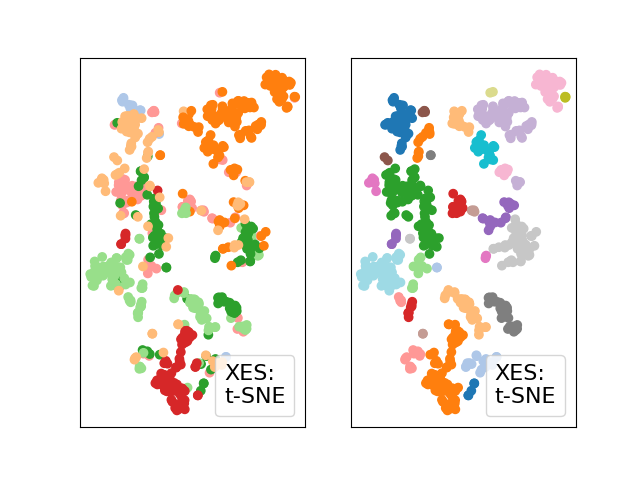

In [129]:
fig, axes = plt.subplots(1,2)
subplots = [(fig, ax) for ax in axes]

redspace_dots_clustered = u.plot_dim_red(subplots[0], XES_data, XES_tsnemap, typecodemap, mode='XES')

redspace_dots_categorized = u.plot_dim_red(subplots[1], XES_data, XES_tsnemap, XES_clustermap, mode='XES')

<IPython.core.display.Javascript object>


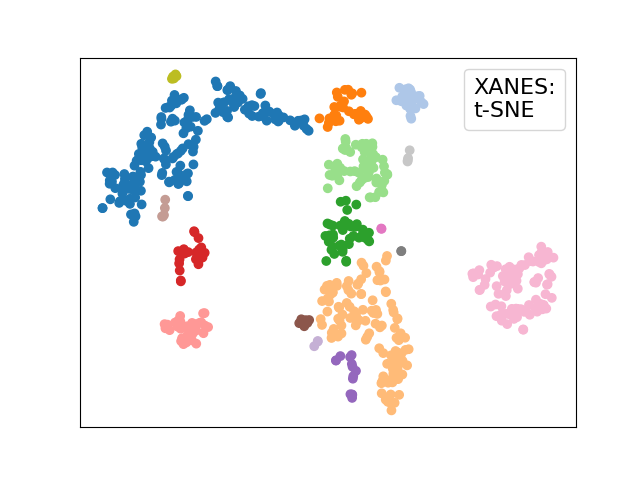

In [37]:
redspace_dots_categorized = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, XANES_clustermap, mode='XANES')

## Download Structure Diagrams

## Compare Clusters within Type

<IPython.core.display.Javascript object>


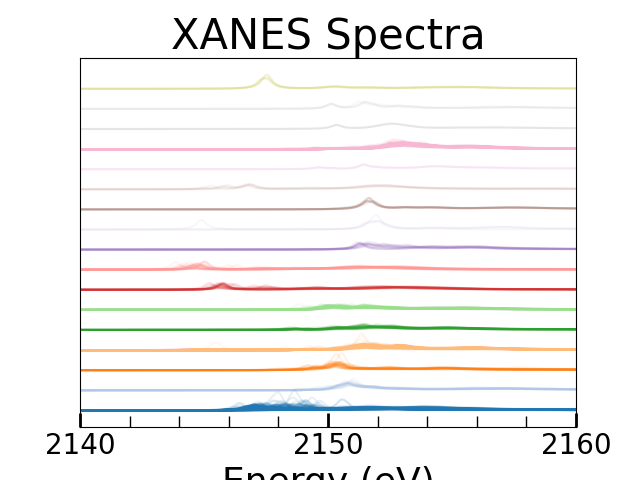

In [130]:
u.plot_spaghetti(plt.subplots(), XANES_data, binmap=XANES_clustermap, colormap=XANES_clustermap, mode='XANES', coloralpha=0.1, energyrange=[2140,2160]);

<IPython.core.display.Javascript object>


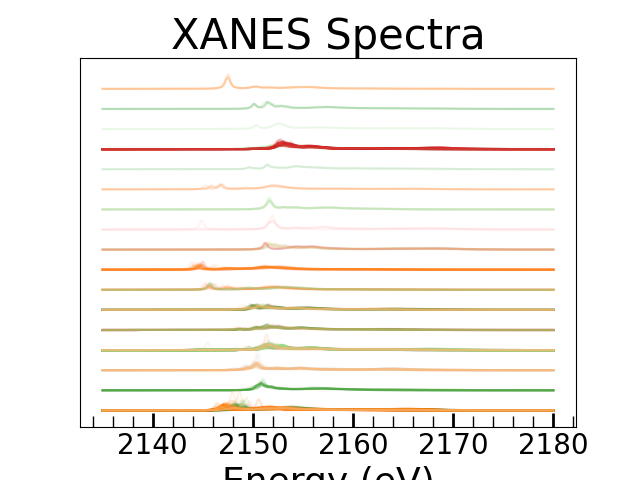

In [39]:
u.plot_spaghetti(plt.subplots(), XANES_data, binmap=XANES_clustermap, colormap=typecodemap, mode='XANES', coloralpha=0.1);

<IPython.core.display.Javascript object>


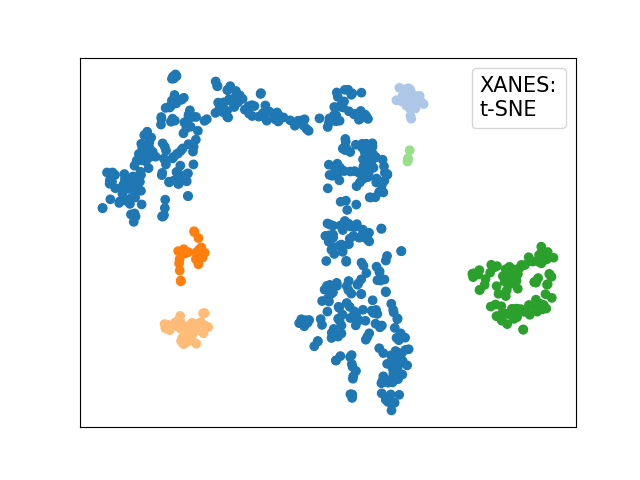

In [217]:
runclustering(5)
plot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, colormap=XANES_clustermap, mode=f'XANES', fontsize=15)
u.add_pubchem_link(plot, XANES_data)
u.add_label(plot, XANES_data, XANES_clustermap)

<IPython.core.display.Javascript object>


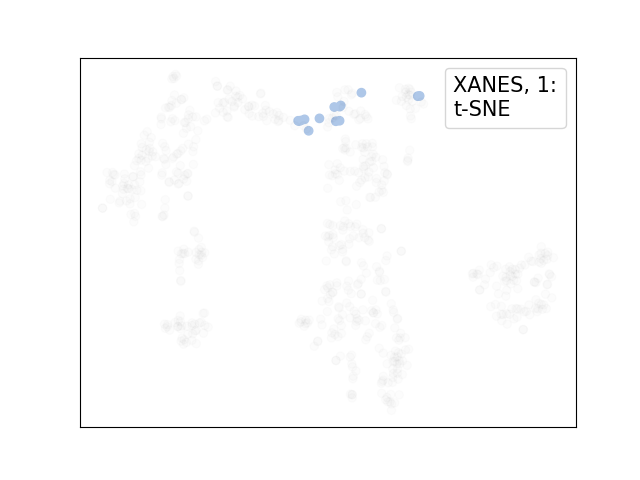

<IPython.core.display.Javascript object>


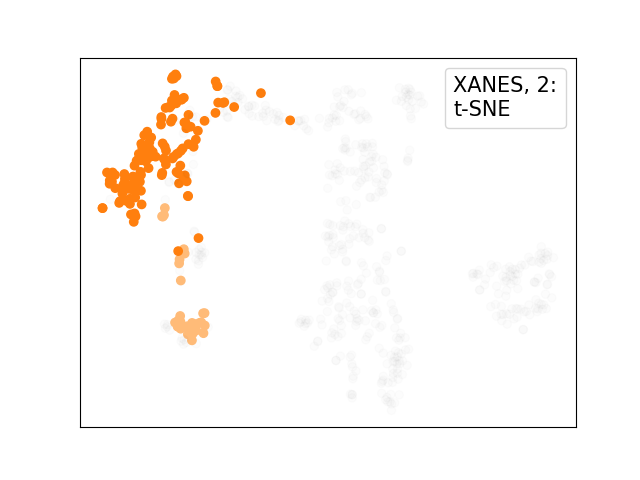

<IPython.core.display.Javascript object>


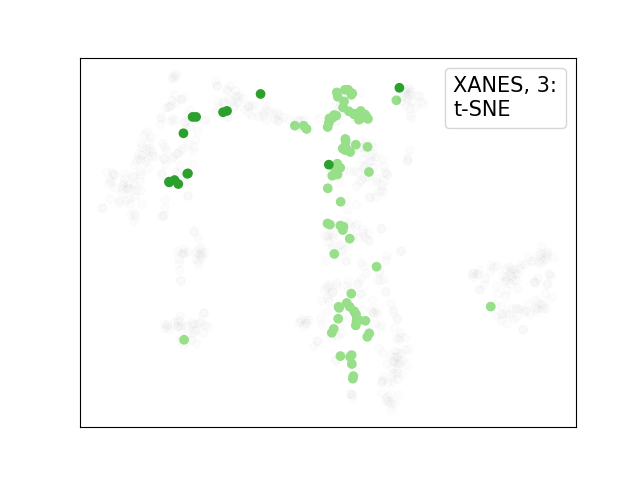

<IPython.core.display.Javascript object>


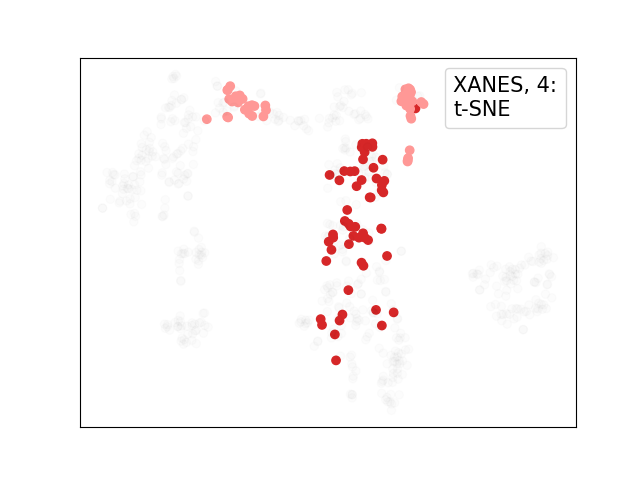

<IPython.core.display.Javascript object>


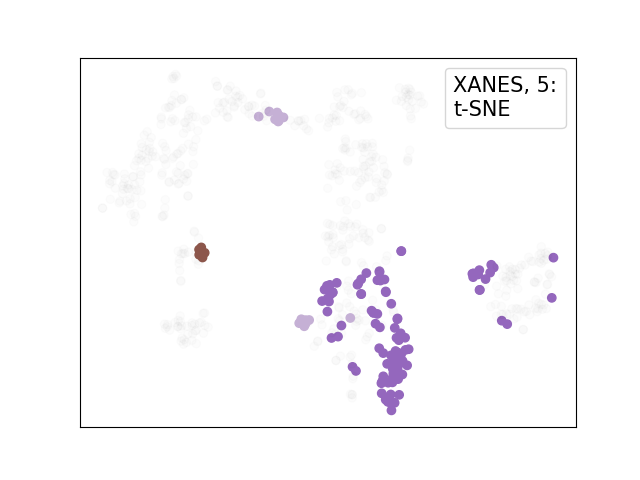

<IPython.core.display.Javascript object>


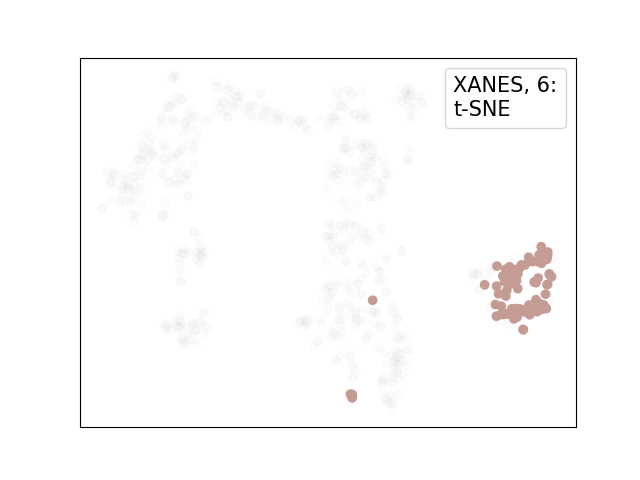

<IPython.core.display.Javascript object>


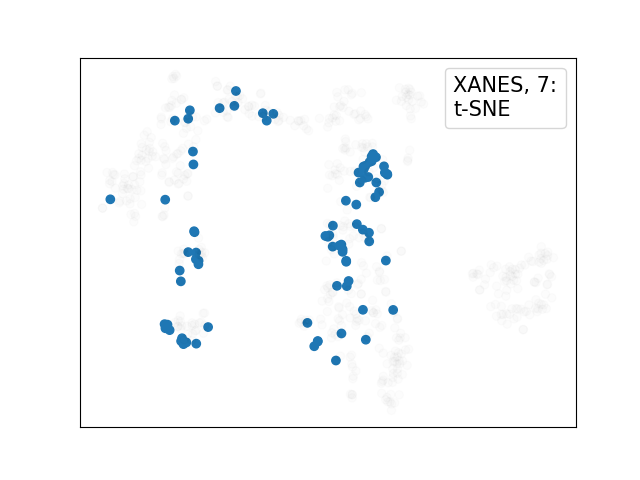

In [216]:
runclustering(3)
for t in range(1,8):
    hidecids = [c['CID'] for c in XANES_data if c['Type']!=t]
    plot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, colormap=classcodemap, hiddencids=hidecids, mode=f'XANES, {t}', fontsize=15)
    u.add_pubchem_link(plot, XANES_data)
    u.add_label(plot, XANES_data, XANES_clustermap)

<IPython.core.display.Javascript object>


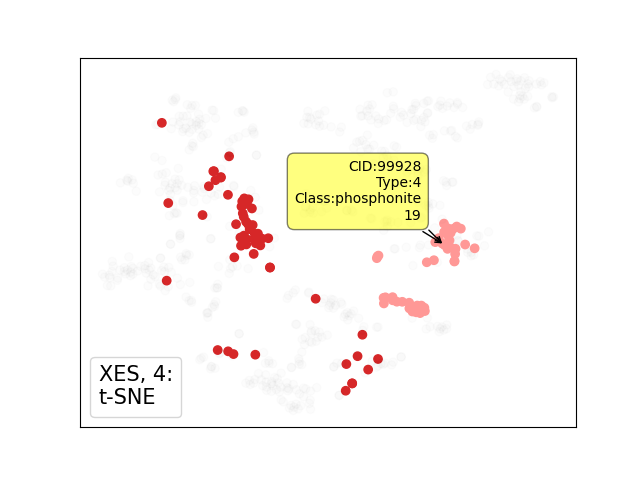

In [59]:
hidecids = [c['CID'] for c in XES_data if c['Type']!=4]
plot = u.plot_dim_red(plt.subplots(), XES_data, XES_tsnemap, colormap=classcodemap, hiddencids=hidecids, mode=f'XES, {4}', fontsize=15)
u.add_pubchem_link(plot, XES_data)
u.add_label(plot, XES_data, XES_clustermap)

### Isolated Clusters

<IPython.core.display.Javascript object>


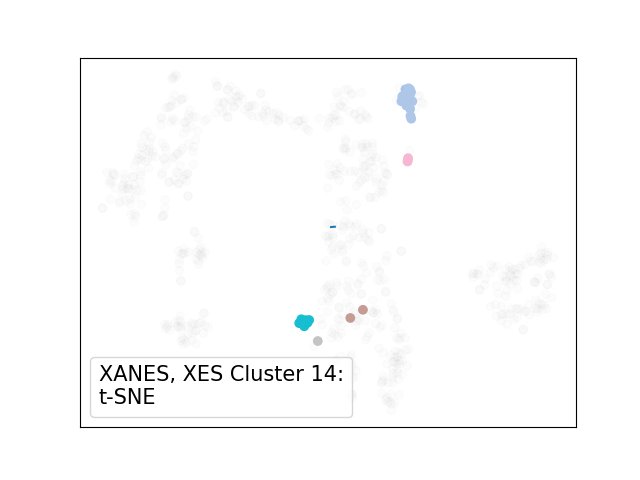

In [174]:
cluster=14
hidecids = [c['CID'] for c in XES_data if XES_clustermap[c['CID']]!=cluster]
plot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, colormap=XANES_clustermap, hiddencids=hidecids, mode=f'XANES, XES Cluster {cluster}', fontsize=15)

<IPython.core.display.Javascript object>


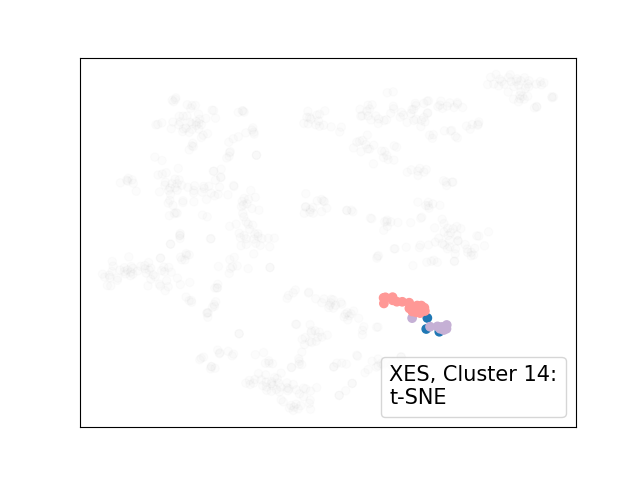

In [173]:
cluster=14
hidecids = [c['CID'] for c in XES_data if XES_clustermap[c['CID']]!=cluster]
plot = u.plot_dim_red(plt.subplots(), XES_data, XES_tsnemap, colormap=classcodemap, hiddencids=hidecids, mode=f'XES, Cluster {cluster}', fontsize=15)
u.add_pubchem_link(plot, XES_data)
u.add_label(plot, XES_data, XES_clustermap)

<IPython.core.display.Javascript object>


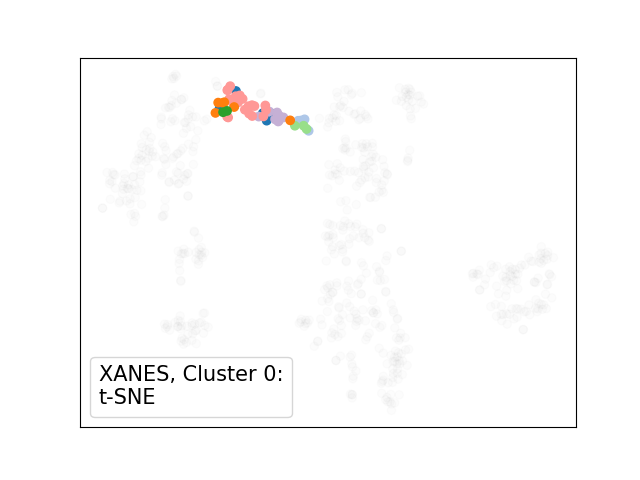

In [172]:
cluster=0
hidecids = [c['CID'] for c in XANES_data if XANES_clustermap[c['CID']]!=cluster]
plot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, colormap=classcodemap, hiddencids=hidecids, mode=f'XANES, Cluster {cluster}', fontsize=15)
u.add_pubchem_link(plot, XANES_data)
u.add_label(plot, XANES_data, XANES_clustermap)

## Group Isolated Spaghetti Plots

<IPython.core.display.Javascript object>


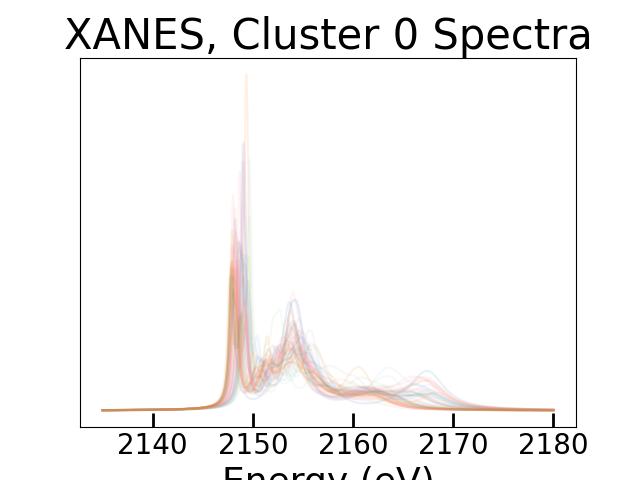

In [81]:
allowedclusters = (0,)
isolated_XANES_data = [c for c in XANES_data if XANES_clustermap[c['CID']] in allowedclusters]
u.plot_spaghetti(plt.subplots(), isolated_XANES_data, binmap=XANES_clustermap, colormap=classcodemap, mode=f"XANES, Cluster {allowedclusters[0]}", coloralpha=0.1);

In [91]:
cids0 = set([c['CID'] for c in XANES_data if XANES_clustermap[c['CID']]==0])
cids1 = set([c['CID'] for c in XANES_data if XANES_clustermap[c['CID']]==1])
cids14 = set([c['CID'] for c in XES_data if XES_clustermap[c['CID']]==14])
cids19 = set([c['CID'] for c in XES_data if XES_clustermap[c['CID']]==19])

In [111]:
l = list(cids1.intersection(cids14))
for i in range(0,len(l)):
    webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={l[i]}&t=l")

In [103]:
len(cids1)

23

In [101]:
cids14.difference(cids1)

{17304,
 17305,
 17522,
 19657,
 25843,
 31200,
 31354,
 104781,
 115123,
 165212,
 168140,
 170990,
 3034435,
 101572300}

<IPython.core.display.Javascript object>


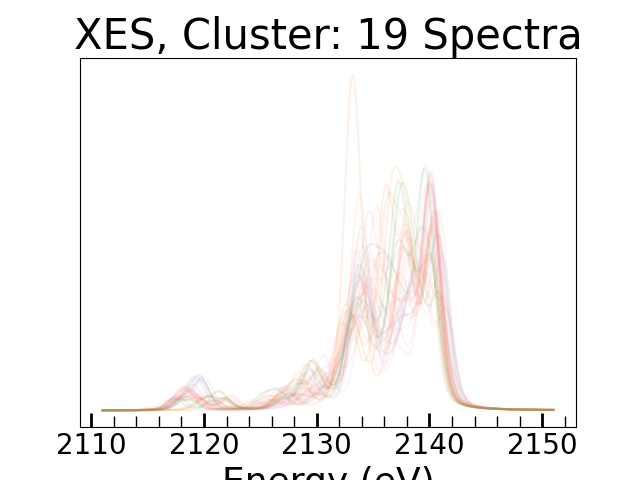

In [86]:
allowedclusters = (19,)
isolated_XES_data = [c for c in XES_data if XES_clustermap[c['CID']] in allowedclusters]
u.plot_spaghetti(plt.subplots(), isolated_XES_data, binmap=XES_clustermap, colormap=classcodemap, mode=f"XES, Cluster: {allowedclusters[0]}", coloralpha=0.1);

## Compare XES and XANES Clustering

In [142]:
XANES_listbycluster = {cluster: [c['CID'] for c in XANES_data if XANES_clustermap[c['CID']]==cluster] for cluster in range(len(set(XANES_clustering.labels_)))}

In [143]:
XES_listbycluster = {cluster: [c['CID'] for c in XES_data if XES_clustermap[c['CID']]==cluster] for cluster in range(len(set(XES_clustering.labels_)))}

## XES vs XANES Clustering Correlation

Given that 2 compounds are in the same XES/XANES cluster, what is the probablility that they also have the same XANES/XES cluster?

Define: For each cluster in XES/XANES, check all distinct pairs of compounds. Divide number of pairs that match XANES/XES cluster by total number of pairs. Average over number of groups. If total number of pairs is zero (singleton clusters), default to zero.

In [166]:
def get_correlation(cids, clusters1, clustermap1, clustermap2):
    matchfrac_count = 0
    for cluster in clusters1:
        clustercids = [cid for cid in cids if clustermap1[cid]==cluster]
        matchcount = 0
        if len(clustercids)==1:
            continue
        for i,cid1 in enumerate(clustercids):
            for cid2 in clustercids[i+1:]:
                if clustermap2[cid1]==clustermap2[cid2]:
                    matchcount+=1
        matchfrac_count += matchcount/(2*len(clustercids)*(len(clustercids)-1))
    return matchfrac_count/len(clusters1)

In [168]:
XANES_clusters = set(XANES_clustering.labels_)
XES_clusters = set(XES_clustering.labels_)
print(get_correlation(CIDs, XANES_clusters, XANES_clustermap, XES_clustermap))
print(get_correlation(CIDs, XES_clusters, XES_clustermap, XANES_clustermap))

0.09058235770473762
0.11867811948715642


In [208]:
XES_XANES_corr = []
XANES_XES_corr = []

for eps in np.linspace(1,5,41):
    runclustering(eps)
    XANES_clusters = set(XANES_clustering.labels_)
    XES_clusters = set(XES_clustering.labels_)
    print(f"EPS: {eps}")
    XANES_XES_corr.append(get_correlation(CIDs, XANES_clusters, XANES_clustermap, XES_clustermap))
    XES_XANES_corr.append(get_correlation(CIDs, XES_clusters, XES_clustermap, XANES_clustermap))
    print(len(XANES_clusters))
    print(len(XES_clusters))

EPS: 1.0
319
302
EPS: 1.1
274
259
EPS: 1.2
236
219
EPS: 1.3
203
186
EPS: 1.4
173
162
EPS: 1.5
144
141
EPS: 1.6
119
124
EPS: 1.7000000000000002
105
115
EPS: 1.8
90
101
EPS: 1.9
77
91
EPS: 2.0
68
80
EPS: 2.1
60
73
EPS: 2.2
50
67
EPS: 2.3
43
60
EPS: 2.4000000000000004
39
55
EPS: 2.5
35
51
EPS: 2.6
30
49
EPS: 2.7
22
44
EPS: 2.8
20
38
EPS: 2.9000000000000004
19
36
EPS: 3.0
17
36
EPS: 3.1
16
34
EPS: 3.2
15
34
EPS: 3.3000000000000003
14
30
EPS: 3.4000000000000004
13
27
EPS: 3.5
11
24
EPS: 3.6
11
21
EPS: 3.7
9
18
EPS: 3.8000000000000003
7
16
EPS: 3.9000000000000004
7
13
EPS: 4.0
6
12
EPS: 4.1
6
11
EPS: 4.2
6
10
EPS: 4.300000000000001
6
10
EPS: 4.4
6
9
EPS: 4.5
6
8
EPS: 4.6
6
8
EPS: 4.7
6
8
EPS: 4.800000000000001
6
8
EPS: 4.9
6
8
EPS: 5.0
6
7


In [200]:
XES_XANES_corr

[]

In [213]:
runclustering(3)

In [214]:
len(set(XES_clustering.labels_))

36

<IPython.core.display.Javascript object>


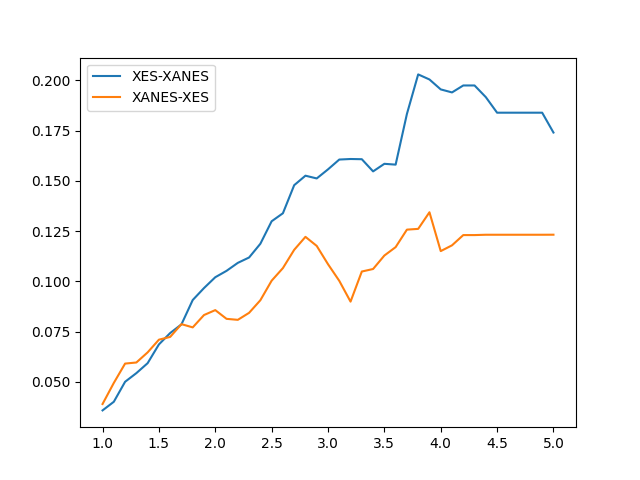

In [209]:
plt.figure()
plt.plot(np.linspace(1,5,41), XES_XANES_corr, label='XES-XANES')
plt.plot(np.linspace(1,5,41), XANES_XES_corr, label='XANES-XES')
plt.legend()